# DELIVERABLE 2

### We are trying to deliver several cities in an optimized way using the ant colony algorithm. We are also looking to use more than one truck to be able to separate the path and deliver more quickly.

## STEP 2: Random data generation

We start by generating points with random coordinates.<br>
We also generate a volume of demand for each city.<br>
The distance matrix is then calculated between each point.<br>
And we end up placing the preceding gener points in a graph that will be saved in a PNG file.<br>

In [135]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.spatial import distance_matrix

number_cities = 20

'''
Generate city names in alphabetical order
'''
cities = []

for i in range(number_cities):
    city = chr(ord('A') + i)
    cities.append(city)

'''
Origin of the graph
'''
depot_longitude       =  -100.971533
depot_latitude        =  49.055688

'''
Generate random coordinates
'''
longitude = np.random.normal(depot_longitude, 10, number_cities)
latitude  = np.random.normal(depot_latitude, 10, number_cities)


'''
We randomly generate the volume of demand (in m3) for each city
'''
demands = np.random.randint(1, 11, number_cities-1)
demands = np.insert(demands,0,0)


'''
Insert coordinates in a matrix
'''
coords  =  []
k       =  0
for citie in range(len(cities)):
    coords.append([longitude[k], latitude[k]])
    k += 1

np_coords = np.array(coords)

print(coords)

[[-110.2685682053355, 53.403254400246695], [-99.21564051166492, 32.46829892591739], [-80.47546705035285, 44.627703613623126], [-96.55525068168485, 45.92539555877503], [-99.2194244033896, 51.89870222390941], [-94.19866746206279, 60.72543160580841], [-104.40001385892029, 39.87373747265171], [-96.23993890981956, 25.125849748679407], [-97.04395112794037, 32.11145238909357], [-101.95060845199798, 53.24892039826028], [-107.36246222310187, 50.01369068773408], [-91.65029019201495, 44.49416348859635], [-110.10086775658348, 55.995718253731695], [-88.07367543294424, 45.09425396281335], [-93.24179880576894, 48.96339789340175], [-101.17069892165135, 46.466187712337664], [-85.43725214294558, 51.32116177743146], [-113.71811016689584, 56.4764529973608], [-93.26629946274284, 50.56365646759315], [-107.05038063349778, 49.417579348845905]]


The position of the warehouse and the cities to be delivered is displayed on a 2D map.

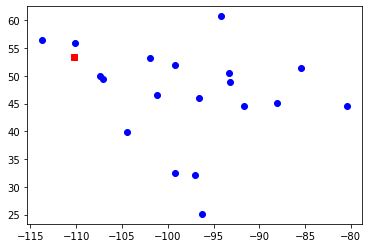

In [136]:
x, y = np_coords.T                          # We define that the first value of coords is X and the second is Y
plt.plot(x[0], y[0], c='r', marker='s')
plt.scatter(x[1:],y[1:], c='b')             # Put the x and y axis in pyplot
plt.show()                                  # Display the coordinates of the cities on an orthonormal coordinate system

In [137]:
'''
Generate city names in alphabetical order
'''
cities = []

for i in range(number_cities):
    city = chr(ord('A') + i)
    cities.append(city)

'''
Creation of the matrix of distances between cities
'''

df      = pd.DataFrame(coords, columns=['longitude', 'latitude'],    index=cities)

df_map = pd.DataFrame({"longitude":longitude,
                       "latitude":latitude,
                       "demand":demands},  index=cities)


print(df_map)

matrix   = distance_matrix(df.values, df.values)

distance = pd.DataFrame(matrix, index=df.index, columns=df.index)

print(distance)

    longitude   latitude  demand
A -110.268568  53.403254       0
B  -99.215641  32.468299       7
C  -80.475467  44.627704       1
D  -96.555251  45.925396      10
E  -99.219424  51.898702       8
F  -94.198667  60.725432       5
G -104.400014  39.873737       7
H  -96.239939  25.125850       3
I  -97.043951  32.111452       9
J -101.950608  53.248920       2
K -107.362462  50.013691       2
L  -91.650290  44.494163       6
M -110.100868  55.995718       6
N  -88.073675  45.094254       9
O  -93.241799  48.963398       4
P -101.170699  46.466188       9
Q  -85.437252  51.321162       7
R -113.718110  56.476453       8
S  -93.266299  50.563656       8
T -107.050381  49.417579       6
           A          B          C          D          E          F  \
A   0.000000  23.673605  31.058641  15.619649  11.151110  17.659445   
B  23.673605   0.000000  22.339320  13.717548  19.430404  28.699052   
C  31.058641  22.339320   0.000000  16.132063  20.104809  21.153323   
D  15.619649  13.717548

## Now we try to calculate the distance thanks to longitude and latitude

In [138]:
from sklearn.neighbors import DistanceMetric

df_rad = df.copy()

# We put our coordinates in radian
df_rad['longitude']  = np.radians(df_rad['longitude'])
df_rad['latitude']   = np.radians(df_rad['latitude'])

print(df_rad)

dist = DistanceMetric.get_metric('haversine')

# We calculate the distance between the data and we fill a matrix
dist.pairwise(df_rad [['longitude','latitude']].to_numpy())*6373
matrix_rad   = dist.pairwise(df_rad [['latitude','longitude']].to_numpy())*6373
distance_rad = pd.DataFrame(matrix_rad, columns=cities, index=cities)

print(distance_rad)

   longitude  latitude
A  -1.924550  0.932063
B  -1.731640  0.566679
C  -1.404562  0.778900
D  -1.685207  0.801549
E  -1.731706  0.905803
F  -1.644077  1.059859
G  -1.822124  0.695928
H  -1.679704  0.438529
I  -1.693736  0.560451
J  -1.779374  0.929369
K  -1.873828  0.872904
L  -1.599599  0.776570
M  -1.921623  0.977310
N  -1.537176  0.787043
O  -1.627376  0.854573
P  -1.765762  0.810988
Q  -1.491161  0.895723
R  -1.984755  0.985700
S  -1.627804  0.882502
T  -1.868382  0.862499
             A            B            C            D            E  \
A     0.000000  2489.700959  2360.027800  1287.137690   763.301352   
B  2489.700959     0.000000  2109.163402  1514.055081  2161.240540   
C  2360.027800  2109.163402     0.000000  1264.640861  1599.535360   
D  1287.137690  1514.055081  1264.640861     0.000000   692.240417   
E   763.301352  2161.240540  1599.535360   692.240417     0.000000   
F  1262.124410  3164.247326  2006.278129  1653.367166  1028.765250   
G  1568.875099   945.703058

## We display on a 2D graph the distance between each point (previously calculated)

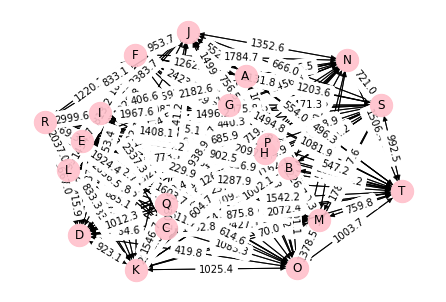

In [139]:
G        = nx.from_numpy_matrix(np.matrix(distance_rad.round(1)), create_using=nx.DiGraph)  # Convert our matrix to a matrix readable by networkx
layout   = nx.spring_layout(G)                                                          # Position the nodes in a plane
labels   = nx.get_edge_attributes(G, "weight")                                          # We recover the weight of the edges

for i in range(number_cities):                                    # Add the name of the cities
    G.add_node(i, desc=cities[i])

node_labels = nx.get_node_attributes(G, 'desc')                   # Get the names of cities
    
nx.draw(G, layout, edge_color='black', width=1, linewidths=1,\
        node_size=500, node_color='pink', alpha=0.9)              # Graph configuration

nx.draw_networkx_labels      (G, pos=layout, labels=node_labels)  # We add the labels of the nodes to the graph
nx.draw_networkx_edge_labels (G, pos=layout, edge_labels=labels)  # We add the labels of the edge to the graph
plt.savefig("Graph/Graph.png", format="PNG")                            # We save the graph in a png file
plt.show()                                                        # Display the graph

## <strong> STEP 3: Modeling the problem </strong>

### - Definition of the formal problem

The ADEME wants to find new solutions to regulate and reduce the environmental impact of products deliveries.

For this, our structure CesiCDP must put in place new technologies to optimize the management of resources and the logistics of road traffic. So, we must manage a delivery round thanks to operational research and the VRP (Vehicle Routing Problem) problem.
 
The algorithmic problem therefore consists in calculating a route on a road network making it possible to link a subset of cities together, then to return to its starting point, to minimize the total duration of the tour. This optimization will have to take into account the traffic planned on each axis for the different time slots.

### Mathematical formulation :  

The VRP formulation that we present here corresponds to the mathematical formulation used in linear integer programming. It translates the natural modeling of the problem by the definition of a binary variable Xijk equal to 1 if the vehicle k crosses the arc (Vi, Vj), denoted more simply (i, j).
 
We assume that the graph G = (V, E) is complete, so that all the vertices are connected to each other. This means that a city can be visited from any other city.
  
  
The other constants of the problem are as follows:  
<strong> n </strong> number of clients (or vertices) 
<strong> m </strong> number of vehicles  
<strong> Q </strong> vehicle capacity  
<strong> qi </strong> request from client i  
<strong> Cij </strong> the cost of the edge between vertices i and j (distance or travel time)  

The decision variables of the problem are the <strong> xijk </strong> mentioned above:  
  
<strong> Xijk = 1 if (i, j) </strong> is traveled by vehicle <strong> k </strong>,  
<strong> Xijk = 0 </strong> otherwise.  
 
Thus, as an optimization problem, the VRP is written:

### 1) $\sum \limits _{i=1} ^{n} \sum \limits _{i=1} ^{m} Cij \sum \limits _{i=1} ^{m} Xijk$

<br>

A complete graph with n vertices has n (n − 1) 2 edges:  

### 2)  $\sum \limits _{i=1} ^{n} \sum \limits _{k=1} ^{m} Xijk = 1 ∀ 1 ≤ j ≤ n$

### 3)  $\sum \limits _{j=1} ^{n} \sum \limits _{k=1} ^{m} Xijk = 1 ∀ 1 ≤ i ≤ n$

### 4)  $\sum \limits _{i=1} ^{n} \sum \limits _{l=1} ^{n} Xijk = \sum \limits _{l=1} ^{n}\sum \limits _{j=1} ^{n} Xijk$

### 5)  $\sum \limits _{j=1} ^{n} X0jk = 1 ∀ 1 ≤ k ≤ m$

### 6)  $\sum \limits _{i=1} ^{n} Xi0k = 1 ∀ 1 ≤ k ≤ m$

### 7)  $\sum \limits _{i=1} ^{n} \sum \limits _{j=1} ^{n} Xijk ≤ Q ∀ 1 ≤ k ≤ m$


#### Xijk ∈ 0, 1 ∀ 0 ≤ i, j ≤ n; 1 ≤ k ≤ m

Under this formulation, 
(1) means that the objective of the optimization problem is to minimize the sum of the costs of all the routes.  
The constraints (2) and (3) require that each customer be served once and only once and the constraints (4) ensure flow conservation.  
Constraints (5) ensure that each tour begins and ends at the depot.  
Finally, the constraints (6) are the capacity constraints and the constraints (7) are binary constraints on the Xijk decision variables.
<br>
<br>
**Resources: Synthèse du problème de routage de véhicules - Collection des rapports de recherche de Télécom Bretagne - RR-2011-03-LUSSI**<br>
The document is located in the "Resources" folder.


### - The complexity study of this problem

### Proof that VRP has "at least" the complexity of TSP  

The problem of vehicle tours is NP-Hard.  
  
Since this is not a decision problem (its return type is not bool), it cannot be in NP, although it has decision versions that are.  
  
This problem is a natural generalization of a problem that is already NP Difficult, in particular the traveling salesman problem or TSP. To prove that a problem is NP-Hard, reduces  it to another NP-Hard problem. The TSP is trivially reduced to a VRP instance with an available vehicle.  
  
  
  
### Proof that TSP is NP-Complete  

You have to show two things, that Traveling Salesman (TSP) is in NP and that TSP is NP-Hard. These requirements derive from the definition of NP-Completeness.  

**Part 1: TSP is in NP**

Proof: Let S be an index which is a sequence of vertices V = v1, ..., vn.  
We then check two things, that each edge crossed by adjacent vertices is an edge in G (usually not necessary, since G is traditionally a complete graph), such that the sum of these edge weights is less than or equal to k.  
Second, we check that every vertex of G is in V, which ensures that every node has been crossed. We accept S if and only if S satisfies these two questions, otherwise we reject. These two checks are clearly polynomial, so our algorithm forms a checker with the index S, and TSP is therefore in NP.
  
  
**Part 2: TSP is NP-Hard**


Proof: To show that TSP is NP-Hard, we have to show that any problem y in NP reduces to TSP in polynomial time.  
   
To do this, consider the decisional version of the Hamiltonian cycle (HC). It is well known that HC is NP-Complete, therefore HC is NP-Hard and each "Y" problem in NP reduces to HC in polynomial time. If we reduce HC to TSP in polynomial time, then we will have shown that any "Y" in NP reduced to TSP is a polynomial time, since the sum of two polynomials is also a polynomial.  
  
  
**Recall that the decision version of HC is:**  
Given a graph G = (V, E), is there a simple cycle in G that run through each vertex exactly once?  
Now observe that a simple cycle over n vertices has n edges.  
  
  
  
**Now to reduce HC to TSP use the following algorithm:**  
   
Take G = (V, E), set all edge weights equal to 1, and let k = | V | = n,  k is equal to the number of nodes in G.  
Any edge that is not at the origin in G then receives a weight of 2 (traditionally TSP is on a complete graph, so we have to add these extra edges). Then pass this modified graph in TSP, asking if there is a turn on G with a cost of at most k.  
If the answer to TSP is YES, then HC is YES. Likewise, if TSP is NO, then HC is NO.  
   
Proof: We have to show that the reduction takes a polynomial time and that the solutions of HC correspond 1-1 with the solutions of TSP using the reduction. Obviously, the reduction takes a polynomial time, so we end up with the latter.  
   
First direction: HC has a YES response => TSP has a YES response.   
Proof: If HC has a YES answer, then there exists a simple cycle C which visits each node exactly once, so C has n edges. Since each edge has a weight of 1 in the corresponding TSP instance for the edges that are in the HC graph, there is a round of weight n. Since k = n, and given that there is a round of weight n, it follows that TSP has a YES answer.  
   
Second direction: HC has a NO response => TSP has a NO response. Proof: If HC has an answer NO, then there is no simple cycle C in G that visits each vertex exactly once.  
Now suppose that TSP has a YES response. Then there is a tower that visits each vertex once with a weight of at most k. Since the tour requires that each node be crossed, there are n edges, and since k = n, each edge crossed must have a weight of 1, which implies that these edges are in the graph HC. Then do this round and cross the same edges in the HC instance. This forms a Hamiltonian cycle, a contradiction.  
   
This concludes part 2. Since we have shown that TSP is in both NP and NP-Hard, we have that TSP is NP-Complete, as required.  
  
  
### Conclusion

**Given that VRP is "at least" of the same complexity as TSP and that VRP is not NP. This means that VRP is necessarily NP-hard.**

# WIP: LA SUITE C'EST EN COURS DE REALISATION

# STEP 4 : Algorithmic Modeling

## 1 - Description of the algorithm used to solve VRP

### Why use the ant colony algorithm ?

According to studies carried out to know the best algorithm.  
   
For a little number of nodes:   
     
Taboo search and simulated annealing have better performance than other algorithms. Whether it is on the quality of the solution, the speed of the algorithm but also on the stability of the results, taboo search and simulated annealing have the best performances. It has been noted that the difference in the quality of the solution is particularly visible for larger test cases.  
   
For a case of a large number of nodes: The taboo search and simulated annealing methods give a solution with very similar and powerful differences. But a better result in almost all cases gives the ant colony optimization algorithm.  
 
**Conclusion :**  
The most suitable algorithm is therefore the ant algorithm, because we have a large number of nodes.

**Resources of the two scientific studies :**  
https://dk.upce.cz/bitstream/handle/10195/66616/Comparison%20of%20metaheuristic%20methods%20by%20solving%20travelling%20salesman%20problem.pdf?sequence=1&isAllowed=y <br>
https://www.researchgate.net/publication/312889331_Choice_of_best_possible_metaheuristic_algorithm_for_the_travelling_salesman_problem_with_limited_computational_time_Quality_uncertainty_and_speed

### Explanation of the ant colony algorithm

The original idea comes from the observation of the ant’s exploitation of food resources. Indeed,  although individually having limited cognitive abilities, are collectively able to find the shortest path between a food source and their nest.<br>
 <br>
Biologists have observed, in a series of experiments carried out starting in 1989, that an ant colony having the choice between two paths of unequal length leading to a food source tended to use the shorter path.<br>
A model explaining this behavior is as follows:<br>
 <br>
1.	an ant (called a "scout") roams more or less randomly in the environment around the colony;<br>
2.	if it discovers a source of food, it returns more or less directly to the nest, leaving a trail of pheromones in its path;<br>
3.	these pheromones being attractive, the ants passing nearby will tend to follow, more or less directly, this trail;<br>
4.	returning to the nest, these same ants will reinforce the trail;<br>
5.	if two tracks are possible to reach the same food source, the shorter one will be, at the same time, traveled by more ants than the long one;<br>
6.	the short track will therefore be more and more reinforced, and therefore more and more attractive;<br>
7.	the long track will eventually disappear, the pheromones being volatile;<br>
8.	eventually, all the ants determined and "chose" the shortest trail.<br>
 <br>
 <br>
 <br>
The ant colony algorithm aims to solve the traveling salesman problem, where the goal is to find the shortest path to connect a set of cities.<br>
The general algorithm is relatively simple, and relies on a set of ants, each traveling a path among those possible.<br>
At each step, the ant chooses to move from one city to another according to few rules:<br>
 <br>
•	she can only visit each city once;<br>
•	the further a city is, the less likely it is to be chosen (this is "visibility");<br>
•	the greater the intensity of the pheromone track placed on the ridge between two towns, the more likely the route will be chosen;<br>
•	once its journey is complete, the ant deposits more pheromones on all the edges traveled if the journey is short;<br>
•	the pheromone tracks evaporate with each iteration.<br>

**Resources :** <br>
https://fr.wikipedia.org/wiki/Algorithme_de_colonies_de_fourmis <br>
https://www.i3s.unice.fr/~crescenz/publications/travaux_etude/colonies_fourmis-200605-rapport.pdf <br>
http://villemin.gerard.free.fr/aMaths/Topologi/aaaGraph/Fourmis.htm <br>

## 2 - Python code implementing the model

Now we recover all the information we need for setting up the algorithm.<br>
That is to say :<br>
- The distances matrix<br>
- The total number of car over the 5 days<br>
- The total number of car over the 5 days in the morning and the evenings<br>
- The total number of car per day and by edge<br>
- The total number of car per day and by hours, but also by edge<br>

In [140]:
from pymongo  import MongoClient
import pprint

client                     =  MongoClient('localhost', 27017)
db                         =  client['DataProject']
collection_trafic_stamped  =  db['vehicules_stamped']

'''
Distance Matrix
'''
print(distance_rad)

'''
Total number of cars
'''
total_car  = collection_trafic_stamped.aggregate([{"$group":{"_id":'',"nb_vehicules":{"$sum":'$nb_vehicules'}}},{"$project":{"_id":0,"Total_Vehicules":'$nb_vehicules'}}])
total_car  = list(total_car)[0]

print(total_car)
print("------------------------------------------- \n")
'''
Total number of cars morning and evening
'''
morning_car = 0
evening_car = 0

for x in collection_trafic_stamped.find({}, {"_id":0, "date":1, "nb_vehicules":1}):
    if x["date"].hour < 12:
        morning_car += x["nb_vehicules"]
    else:
        evening_car += x["nb_vehicules"]

print("Morning car number :", morning_car)
print("Evening car number  :", evening_car)
print("------------------------------------------- \n")

             A            B            C            D            E  \
A     0.000000  2489.700959  2360.027800  1287.137690   763.301352   
B  2489.700959     0.000000  2109.163402  1514.055081  2161.240540   
C  2360.027800  2109.163402     0.000000  1264.640861  1599.535360   
D  1287.137690  1514.055081  1264.640861     0.000000   692.240417   
E   763.301352  2161.240540  1599.535360   692.240417     0.000000   
F  1262.124410  3164.247326  2006.278129  1653.367166  1028.765250   
G  1568.875099   945.703058  2031.324985   927.369418  1395.474570   
H  3355.455612   866.547861  2592.487338  2313.701158  2988.606745   
I  2593.180863   208.019115  1999.058717  1537.094522  2208.013149   
J   552.541447  2321.731867  1828.130187   902.110480   237.966103   
K   426.840313  2064.101187  2101.023851   923.138137   607.443867   
L  1674.499559  1489.403702   885.056132   415.938197   995.456822   
M   288.560477  2749.337375  2427.117666  1462.808163   844.179392   
N  1846.505028  1700

In [141]:
'''
Total number of cars per day
'''
days             =  [1, 2, 3, 4, 5]
dict_total_day_  =  {}

for day in days:
    total_vehicles_day = list(collection_trafic_stamped.aggregate([
        {"$project":{"arete":1, "date":{"$dateToParts": { "date": "$date" }}, "nb_vehicules":1}},
        {"$match":{"date.day":day}}, 
        {"$group":{"_id":"$date.day", 
            "nb_vehicules":{"$sum":"$nb_vehicules"}}}, 
        {"$sort":{"_id": 1}} 
    ]))
    dict_total_day_["total_vehicles_day_%s" % (day)] = total_vehicles_day

'''
Total number of cars per day and per edge
'''
dict_day_  =  {}

for day in days:
    number_vehicles_edge_day = list(collection_trafic_stamped.aggregate([
        {"$project":{"arete":1, "date":{"$dateToParts": { "date": "$date" }}, "nb_vehicules":1}},
        {"$match":{"date.day":day}}, 
        {"$group":{"_id":"$arete", 
            "nb_vehicules":{"$sum":"$nb_vehicules"}}}, 
        {"$sort":{"_id": 1}} 
    ]))
    dict_day_["number_vehicles_day_%s" % (day)] = number_vehicles_edge_day

In [142]:
pprint.pprint(dict_day_["number_vehicles_day_5"][0:5]) # Exemple of total number cars per edge the day 5

[{'_id': 0, 'nb_vehicules': 16841},
 {'_id': 1, 'nb_vehicules': 20009},
 {'_id': 2, 'nb_vehicules': 20384},
 {'_id': 3, 'nb_vehicules': 19057},
 {'_id': 4, 'nb_vehicules': 17320}]


In [143]:
'''
Total number of cars per hour and per edge
'''
days        =  [1, 2, 3, 4, 5]
hours       =  [7, 8, 17, 18]
dict_hour_  =  {}

for day in days:
    for hour in hours:
        number_vehicles_edge_hour = list(db.vehicules_stamped.aggregate([
            {"$project":{"arete":1, "date":{"$dateToParts": { "date": "$date" }}, "nb_vehicules":1}},
            {"$match": 
                {"$and": [
                    {"date.hour":{"$lte":(hour+1), "$gte":hour}},
                    {"date.day": day}
                ]}
            }, 
            {"$group":{"_id":"$arete", 
                "nb_vehicules":{"$sum":"$nb_vehicules"}}}, 
            {"$sort":{"_id": 1}} 
            ]))
        
        dict_hour_["number_vehicles_%s_%s" % (day, hour)] = number_vehicles_edge_hour

In [10]:
pprint.pprint(dict_hour_["number_vehicles_2_8"][0:5]) # Exemple number of car the day 2 and between 8 - 9 hours

[{'_id': 0, 'nb_vehicules': 4523},
 {'_id': 1, 'nb_vehicules': 4425},
 {'_id': 2, 'nb_vehicules': 4928},
 {'_id': 3, 'nb_vehicules': 4586},
 {'_id': 4, 'nb_vehicules': 4913}]


## 3 - linear model

We seek to obtain the lower terminal of the optimal solution.<br>
But also the algorithmic bounds.<br>
(We do not take into account the traffic of cars in the calculated terminals).<br>

In [144]:
'''
We create a matrix with the number of vehicles per day and per edge
'''
list_vehicule = []
i = 1

matrix_car_day = [[x['nb_vehicules'] for x in dict_day_[day]] for day in dict_day_]

matrix_car_day = np.transpose(matrix_car_day)

print(matrix_car_day)

[[17345 17183 16677 17022 16841]
 [19619 19746 19476 19416 20009]
 [20002 20339 20209 20820 20384]
 ...
 [21596 21560 21330 21916 21783]
 [18296 18258 18438 18463 18682]
 [21359 21589 21970 21800 22064]]


In [145]:
from pulp import *
'''
Lower Bound of the optimal solution
'''
# values bounds
min_dist = np.min(matrix_rad[np.nonzero(matrix_rad)])
max_dist = np.max(matrix_rad[np.nonzero(matrix_rad)])
min_car = np.min(matrix_car_day)
max_car = np.max(matrix_car_day)

cities_obj = range(number_cities)

# random function
def random_objets(max_dist, max_car):
    distance_path={k: random.randint(round(min_dist),max_dist) for k in range(number_cities)}
    nb_car={k: random.randint(min_car, max_car) for k in range(number_cities)}

    return distance_path,nb_car

#seed
random.seed(a=1)

distance_path, nb_car = random_objets(round(max_dist), max_car)

So we start by doing linear programming. By minimizing it, we get the lower bound.

In [146]:
# variable
x = LpVariable.dicts('cities', cities_obj, 0, 1)

# problem
prob = LpProblem("Optimization", LpMinimize)

# objective function
prob += lpSum([ (distance_path[i] + (nb_car[i]/sum(nb_car))) * x[i] for i in range(number_cities)])

# constaint
prob += lpSum([ distance_path[i] * x[i] for i in range(number_cities)]) >= sum(distance_path.values()) /2

prob.solve()
if (LpStatus[prob.status]=="Optimal"):
    print("lower bound : ")
    print(value(prob.objective))

#print(prob)

lower bound : 
20261.308802787895


For the algorithmic bounds, the following functions are used:<br>
<br>
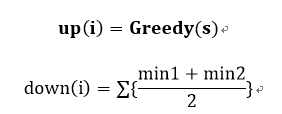
<br>
<br>
For the **upper bound** we use a greedy algorithm.<br>
<br>
The reason why the **lower bound** takes the two minimum values ​​of each row divided by 2 is: <br>
for the city j that passes through each step, from the nearest previous city i to the next nearest city k Go, i.e. j→k. The down obtained in this way must be less than or equal to the optimal solution. Up and down are constantly updated, the value of down will be updated every time a node is reached, and the value of up will be updated every time a solution is found (if it is better than the current up), if the current solution is smaller than the minimum value of all nodes If it is small, the search will be stopped when the optimal solution is found.

In [147]:
'''
Algorithmic - Lower Bound
'''
low  = 0 #lower bound
n    = matrix_rad.shape[0]

for i in range(n):
        
        temp  =  matrix_rad[i].copy()
        temp.sort()

        #print("%s"%(temp[0]))

        low   =  low+temp[0]+temp[1]

low = low / 2

print(low)

3553.1107100350087


In [148]:
'''
Algorithmic - Upper Bound (using greedy algorithm)
'''
INF = 1000000000

up=0

dfs_visited     =  [False]*n
dfs_visited[0]  =  True

def dfs(u,k,l):
    if k==n-1 :
        return (l+matrix_rad[u][0])
    minlen=INF
    p=0
    for i in range(n):
        if dfs_visited[i]==False and minlen>matrix_rad[u][i]:
            minlen=matrix_rad[u][i]
            p=i
    dfs_visited[p]=True
    return dfs(p,k+1,l+minlen)
 
def get_up():
    global up
    up=dfs(0,0,0)

get_up()

print(up)

13045.986248319687


# STEP 5: Implementation and statistical study of experimental behavior

## - The implementation of statistical methods of predictive analysis of traffic on each of the axes of the road network.

In [149]:
df2   = pd.DataFrame(columns=['day 1', 'day 2', 'day 3', 'day 4', 'day 5'], index=cities)
i     = 0

'''
We fill the matrix df2 with the number of cars per day and per city
'''

for city in cities:
    if i >= 500:
        i = 0
    df2.loc[city] = matrix_car_day[i]
    
    i += 1

print(df2)

   day 1  day 2  day 3  day 4  day 5
A  17345  17183  16677  17022  16841
B  19619  19746  19476  19416  20009
C  20002  20339  20209  20820  20384
D  19596  19210  19193  19261  19057
E  17777  17569  17979  17749  17320
F  19828  19622  19183  19843  19243
G  18055  18256  18468  18451  18148
H  19880  19779  20147  20224  19917
I  19397  19364  19572  19544  19137
J  18844  19276  19439  18684  19035
K  19086  19538  19177  18943  19299
L  18215  18409  18004  17960  18398
M  18400  18508  18009  17884  18372
N  19754  20233  19397  19835  20019
O  21051  20882  20722  20831  20369
P  20913  20930  20870  20980  20779
Q  18614  17878  18139  18158  17958
R  16798  16517  16489  16751  16579
S  17179  16888  17187  17572  17247
T  18135  17943  18027  18529  17890


Now we try to create a matrix with the average of the days preceding and the last day. To be able to predict day 6.

In [150]:
import statistics

'''
We create a matrix with
- the average of the cars from the first day to the penultimate day
- the last day
'''

df3   =  pd.DataFrame(columns=['average car', 'last car'], index=cities)
j     =  0


for city in cities:
    if j >= 500:
        j = 0
    average         =   [statistics.mean(matrix_car_day[j][0:4]), matrix_car_day[j][4]]
    df3.loc[city]   =   average
    j += 1

print(df3)

  average car last car
A       17056    16841
B       19564    20009
C       20342    20384
D       19315    19057
E       17768    17320
F       19619    19243
G       18307    18148
H       20007    19917
I       19469    19137
J       19060    19035
K       19186    19299
L       18147    18398
M       18200    18372
N       19804    20019
O       20871    20369
P       20923    20779
Q       18197    17958
R       16638    16579
S       17206    17247
T       18158    17890


We display the number of cars per day and per city in a graph

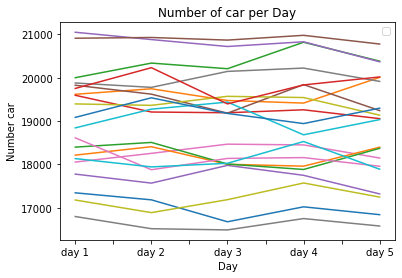

In [151]:
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

df2.T.plot()  
plt.title('Number of car per Day')  
plt.xlabel("Day")
plt.ylabel("Number car") 
plt.legend("")
plt.show()  

Now we display the density of the number of cars per day.

Text(0.5, 0, '5 days')

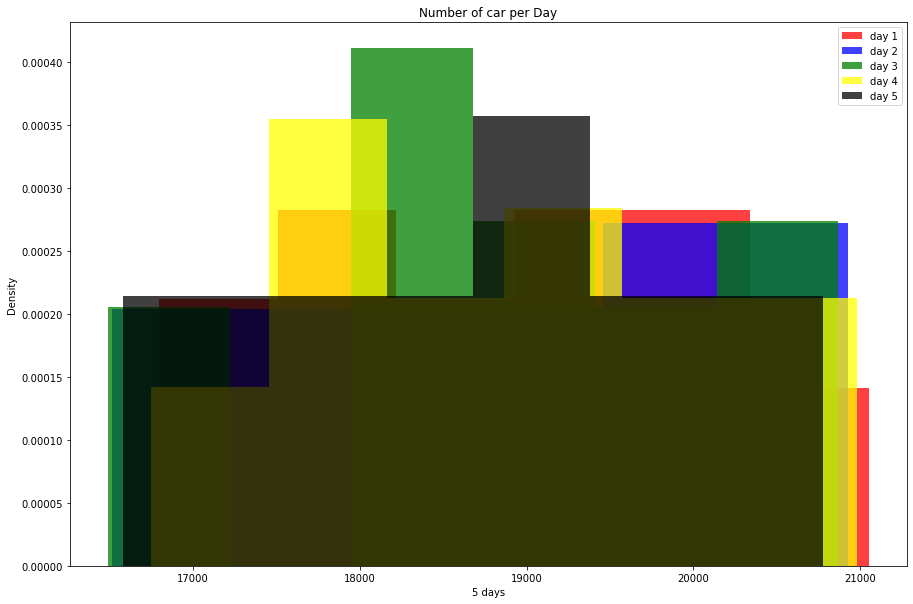

In [152]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.histplot(df2['day 1'], label="day 1", color="red", stat="density", linewidth=0)
seabornInstance.histplot(df2['day 2'], label="day 2", color="blue", stat="density", linewidth=0)
seabornInstance.histplot(df2['day 3'], label="day 3", color="green", stat="density", linewidth=0)
seabornInstance.histplot(df2['day 4'], label="day 4", color="yellow", stat="density", linewidth=0)
seabornInstance.histplot(df2['day 5'], label="day 5", color="black", stat="density", linewidth=0)
plt.title('Number of car per Day')  
plt.legend()
plt.xlabel("5 days")

Now we predict day 6 thanks to the previous matrix with the mean and the last day.

In [153]:
X = df3['average car'].values.reshape(-1,1)
Y = df3['last car'].values.reshape(-1,1)

regressor = LinearRegression()  
regressor.fit(X, Y) #training the algorithm

#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(regressor.score(X, Y)))
print("-------------------------\n\n")

Y_pred = regressor.predict(X)

df4 = pd.DataFrame({'Actual': Y.flatten(), 'Predicted': Y_pred.flatten()})
df4

[81.22207248]
[[0.99084144]]
Variance score: 0.9597058546991499
-------------------------




,Actual,Predicted
0,16841,16981.013736
1,20009,19466.044076
2,20384,20236.918720
3,19057,19219.324557
4,17320,17686.492844
5,19243,19520.540356
6,18148,18220.556382
7,19917,19904.986836
8,19137,19371.914139
9,19035,18966.659989


We can see that we therefore have the prediction of each city for day 6.  
  
We can predict day n + 1 indefinitely, but the more we predict, the less precise it is.  

We put in a graph the difference between the current number of cars and the predicted number.

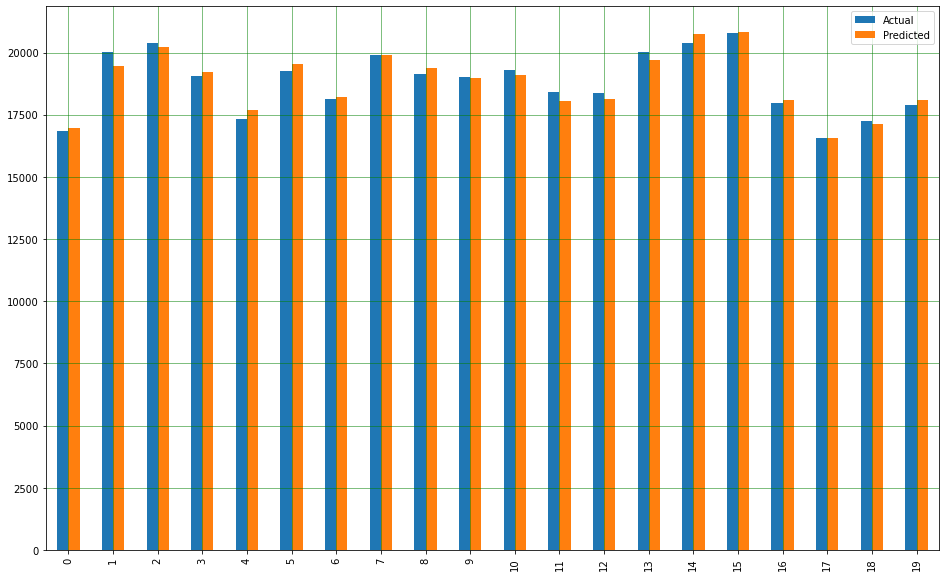

In [154]:
df5 = df4.head(25)
df5.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## - The implementation of the metaheuristic "ant colony algorithm"

The diagram below represents the steps of the ant colony algorithm. This diagram is in the "Resources" folder and it is the "Ant.png" file

![title](Ressources/Ant.png)

The code below is the implementation of the ant colony algorithm for VRP.

In [155]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt


class VPR:

    def __init__(self, capacity, demands, distance_matrix):
        self.n_trucks              =   1                          # Number of trucks
        self.dimension             =   number_cities              # Dimension of the matrix
        self.capacity              =   capacity                   # Capacity for trucks
        self.demands               =   demands                    # List of demands per edge
        self.distance_matrix       =   distance_matrix            # Distance Matrix between edge
        self.distance_matrix_sum   =   distance_matrix.sum()      # Get the sum of all the distance value
        self.final_cost            =   self.distance_matrix_sum   # Final Result / We need a first (worst) value to compare after
        self.final_sol             =   None                       # Final solution of all paths

        self.iterations            =   None                       # Number of iterations
        self.n_ants                =   None                       # Number of ants
        self.alpha                 =   None                       # alpha: exponenet on pheromone, higher alpha gives pheromone more weight
        self.beta                  =   None                       # beta: exponent on distance, higher beta give distance more weight
        self.decay                 =   None                       # decay: Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
        self.init_pheromone_value  =   None                       # Number of pheromone at the start in each edge
        self.pheromone_map         =   None                       # Number of pheromone per edge in a matrix
        self.raw_prob_matrix       =   None                       # Matrix of probability between edge

        self.city_visited          =   None                       # Array of 0 and 1 per city to know if you have been in a city. 0 -> visited and 1 -> not visited.
        self.city_visited_sum      =   None                       # Number of visited cities
        self.capacity_left         =   None                       # Capacity left in a truck


    def get_next_city(self, pos):
        potential      =  deepcopy(self.city_visited)                          # Get the visted cities list (0 -> visited and 1 -> not visited.)
        potential_sum  =  self.city_visited_sum                                # Get the number of visited cities
        while potential_sum < self.dimension:                                  # While we have not visited all the cities we continue to search the next one
            raw_prob_list  =  deepcopy(self.raw_prob_matrix[pos]) * potential  # We get the probability of each cities and we remove the cities already visited -
                                                                               # - by multiplying the potential (0 if a city is already visited)
            prob_list     =   raw_prob_list/raw_prob_list.sum()
            next_vertex   =   np.random.choice(np.arange(0, self.dimension), p=prob_list) # We choose a city randomly by adding the probability per city -
                                                                                          # - (0 if already visited thanks to "raw_prob_list")
            if self.demands[next_vertex] <= self.capacity_left:  # Return the selected vertex if the capacity of the truck is sufficient
                return next_vertex
            potential[next_vertex]  =  0        # We remove the top because the demand is too high (we put the value 0 in the list of cities visited)
            potential_sum          +=  1        # We add the list of cities visited by 1 because we deleted the previous city from the list
        return 0                                # Once you have finally removed all the cities from the list. We return 0, that is to say the city of deposit.

    def local_update(self, i, j):      # Used to update the pheromone map and therefore the probability matrix (after the passage of ONE ant) !!! BUT ONLY FOR THE CURRENT CITY (i) AND THE NEXT ONE (j) !!!
        self.pheromone_map[i, j]  += self.decay * self.init_pheromone_value / self.distance_matrix[i, j]           # We update the pheromone map
        self.pheromone_map[j, i]   = self.pheromone_map[i, j]                                                      # We make sure that the pheromone map is symmetrical with respect to the diagonal 
                                                                                                                   # (So that A-B and B-A have the same number of pheromones in the table for example)
        self.raw_prob_matrix[i, j] = self.raw_prob_matrix[j, i] = (self.pheromone_map[i, j] ** self.alpha) * \
                                                                  ((1 / self.distance_matrix[i, j]) ** self.beta)  # We update the probability matrix thanks to the pheromone map (also symmetrically equal)

    def global_update(self, best_solution, best_cost): # We update the pheromone map and therefore the probability matrix after the end of the passage of ALL the ants (for each iteration)
        for one_path in best_solution:
            for i in range(len(one_path)-1):
                self.pheromone_map[one_path[i], one_path[i + 1]]    += self.decay * self.capacity / best_cost
                self.pheromone_map[one_path[i + 1], one_path[i]]    =  self.pheromone_map[one_path[i], one_path[i + 1]]
                self.raw_prob_matrix[one_path[i], one_path[i + 1]]  =  \
                    self.raw_prob_matrix[one_path[i + 1], one_path[i]] = \
                    (self.pheromone_map[one_path[i], one_path[i + 1]] ** self.alpha) * \
                    ((1 / self.distance_matrix[one_path[i], one_path[i + 1]]) ** self.beta)

    def get_cost(self, solution):
        current_cost = 0
        for i in range(len(solution) - 1):                                                               # -1 to remove the initial deposit in the loop
            current_cost += self.distance_matrix[solution[i], solution[i + 1]]                           # We add the cost of the current city to the next city
            current_cost = current_cost + (current_cost * (sum([df4['Predicted'][solution[i]], df4['Predicted'][solution[i+1]]])/sum(df4['Predicted']))) # We add to the weight the number of cars (with pourcentage)
        return current_cost

    def plot_function(self):                 # Used to display the iteration and the cost in a graph
        box = {'facecolor': 'white',
               'edgecolor': 'black',
               'boxstyle': 'round'}
        plt.figure(figsize=(9.5, 6))
        plt.text(self.iterations - 18, self.show_iteration[4] - 60,
                 f'cost={round(self.final_cost, 2)}, \n'
                 f'iterations={self.iterations}, \n'
                 f'n_ants={self.n_ants}, \n'
                 f'alpha={self.alpha}, \n'
                 f'beta={self.beta}, \n'
                 f'decay={self.decay}, \n'
                 f'init_ph={self.init_pheromone_value}',
                 bbox=box, color='black', fontsize=12)
        plt.plot(np.arange(self.iterations), self.show_cost, 'r')
        plt.plot(np.arange(self.iterations), self.show_iteration, 'k')
        plt.grid()
        plt.title('Evolution of the cost according to the iteration', fontsize=18)
        plt.xlabel('iterations')
        plt.ylabel('cost')
        plt.show()

    def compute(self, iterations, n_ants, alpha, beta, decay, init_pheromone):
        self.iterations            =  iterations
        self.n_ants                =  n_ants
        self.alpha                 =  alpha
        self.beta                  =  beta
        self.decay                 =  decay
        self.init_pheromone_value  =  init_pheromone

        self.pheromone_map         =  np.full(shape=(self.dimension, self.dimension), fill_value=self.init_pheromone_value) # We create a matrix between all the points with the number of pheromones
        np.fill_diagonal(self.pheromone_map, 0)

        np.fill_diagonal(self.distance_matrix, np.inf)

        self.raw_prob_matrix = (self.pheromone_map ** self.alpha) * ((1 / self.distance_matrix) ** self.beta)  # We create the probability matrix between each point using the formula [METTRE LE NOM DE LA FORMULE]

        self.show_iteration  =  []
        self.show_cost       =  []
        for iteration in range(self.iterations):
            best_solution  = None
            best_cost      = self.distance_matrix_sum                    # We initialize with the worst case, the addition of the distance matrix
            for ant in range(self.n_ants):
                current_state           =   0                            # We initialize the position by the deposit as the start
                solutions               =   []                           # Matrix of the solution found by this ant (Addition of one_path_solution)
                one_path_solution       =   [0]                          # Path found for one truck
                self.capacity_left      =   self.capacity                # We initialize the remaining capacity by the basic capacity of a truck
                self.city_visited       =   np.ones(self.dimension)      # We initialize the list of cities visited by only 1 (0 -> visited and 1 -> not visited)
                self.city_visited[0]    =   0                            # We set the first value to 0 (the deposit)
                self.city_visited_sum   =   1                            # We initialize the number of city visited to 1
                while self.city_visited_sum < self.dimension:            # While we have not visited all the cities we start over
                    next_state = self.get_next_city(current_state)       # Get the next vertex (city)
                    if next_state == 0:                                  # "get_next_city" returns 0 if that there is no possible city
                        one_path_solution.append(0)                      # We add the depot city (0) at the end of the solution
                        solutions.append(one_path_solution)              # We add the path found (for one truck) to the final solution
                        one_path_solution   =  [0]                       # We delete the path and we put back 0 (the city of deposit). IT'S A NEW PATH (another truck)
                        current_state       =  0                         # We put the city where we are by the depot like the beginning
                        self.capacity_left  =  self.capacity             # We restore the basic capacity of the truck.
                        continue
                    one_path_solution.append(next_state)                 # We add the city previously found to the path
                    self.capacity_left -= self.demands[next_state]       # We remove the demand of the city in the capacity of the truck
                    self.local_update(current_state, next_state)         # We update the pheromone map and therefore the probability matrix
                    current_state                     =  next_state      # We change the city where we are located by the next city (previously selected)
                    self.city_visited[current_state]  =  0               # We put the city where we just moved in the list of visited cities (The 0 value)
                    self.city_visited_sum            +=  1               # +1 to the number of cities visited
                
                one_path_solution.append(0)                              # We add the city of deposit at the end of the path
                solutions.append(one_path_solution)                      # We add the path found to the solution
                cost = sum([self.get_cost(sol) for sol in solutions])    # We calculate the cost of the paths found and add them up
                assert all(np.unique(np.hstack(solutions)) == np.arange(self.dimension))  # 

                if cost < best_cost:                     # If the cost of the solution is lower than the cost of the BEST solution,
                    best_cost      =  cost               # the best solution is replaced by the solution found previously
                    best_solution  =  solutions

            self.global_update(best_solution, best_cost)  # 
            self.show_iteration.append(best_cost)         # We add the iterations (the cost) to display them in the graph

            if self.final_cost > best_cost:               # If the final cost is higher than the best cost (this is necessarily the case)
                self.final_cost  =  best_cost             # We recover the best solution and its cost in the final solution
                self.final_sol   =  best_solution
                self.show_cost.append(self.final_cost)  
            else:
                self.show_cost.append(self.show_cost[-1])
            # print(f'Iterations: {iterations} | time: {round(time() - time_s, 4)}| best cost: {best_cost}')

        self.final_sol = [(np.array(x) + 1).tolist() for x in self.final_sol]
        self.n_trucks  = len(self.final_sol)

Now we run the ant colony algorithm to know the best path but also the number of trucks needed.<br>
<br>
Variable: <br>
You can change: <br>
- The "capacity" variable to change the capacity of the trucks (in m3).<br>
- The variable "iterations" to choose the number of iterations of the algorithm. <br>
- The number of ants to change the number of ants that will make a path and pose pheromones at each iteration.<br>
<br>
<br>
We get at the end:<br>
- The time taken by the algorithm to give the solution<br>
- The number of cars needed to run the delivery round<br>
- The solution in the form of a table with the number of the towns. Each table represents a truck with its list of city to be delivered (it starts and ends with one each time because it is the depot city)<br>
- And the total cost of all trucks<br>


In [158]:
import time

capacity    =  50 # in m3

case  = VPR(capacity, demands, matrix_rad) # We initialize the variables

start = time.time() # starting time
case.compute(iterations=100, n_ants=20, alpha=1, beta=1, decay=0.5, init_pheromone=1000) # We are looking for the best path
end = time.time() # end time


print(f"Runtime of the program is : {end - start}" + " s")

print("Number of car: ", case.n_trucks)

print("Found solution:", case.final_sol)

print("Final Cost:", case.final_cost)

Runtime of the program is : 4.743485927581787 s
Number of car:  3
Found solution: [[1, 13, 10, 5, 11, 20, 16, 12, 14, 3, 1], [1, 18, 15, 4, 7, 8, 2, 9, 1], [1, 19, 17, 6, 1]]
Final Cost: 28230.995424612498


## The code below automates the algorithm to test it. And fill out the excel to perform statistics.

In [160]:
import time
i = 1
j = 1
y = 0
list_cost = []

for _ in range(10):
    capacity    =  100

    case = VPR(capacity, demands, matrix)


    start = time.time() # starting time
    case.compute(iterations=100, n_ants=20, alpha=1, beta=1, decay=0.5, init_pheromone=1000)
    end   = time.time() # end time
    total = end - start

    print("T%s : %s" % (i, total))
    list_cost.append(case.final_cost)
    #print("C%s : %s" % (i, case.final_cost))
    i += 1

for _ in range(10):
    print("C%s : %s" % (j, list_cost[y]))
    j += 1
    y += 1

T1 : 3.6436774730682373
T2 : 3.592241048812866
T3 : 3.588240623474121
T4 : 4.013315916061401
T5 : 3.758269786834717
T6 : 3.5994014739990234
T7 : 3.5139224529266357
T8 : 3.609419107437134
T9 : 3.8351356983184814
T10 : 3.6270081996917725
C1 : 308.70374898747554
C2 : 307.6048408604576
C3 : 317.7584499709972
C4 : 320.1440986088377
C5 : 311.9798569015134
C6 : 307.436555633283
C7 : 307.23603670888554
C8 : 312.37737445087924
C9 : 324.592163383306
C10 : 319.33183237204025


The graph below shows, for each iterations, the cost of the path. But also the parameters applied in the algorithm. You can also see the minimum cost found in red.

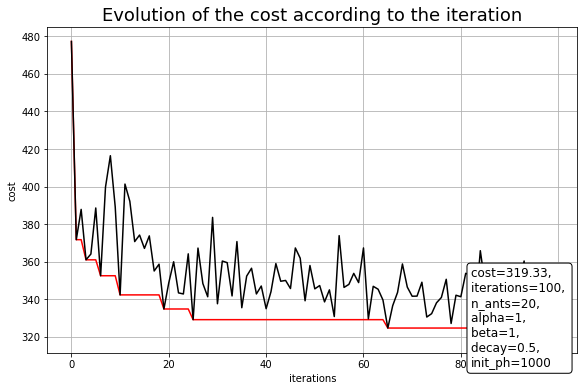

In [161]:
case.plot_function()

The graph below displays the paths found by the algorithm for each truck in a 2D plan.

<function matplotlib.pyplot.show(close=None, block=None)>

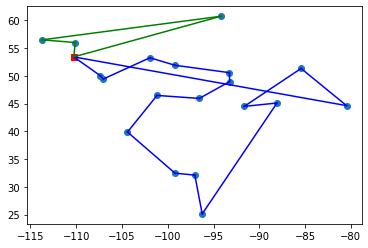

In [162]:
x, y = np_coords.T                          # We define that the first value of coords is X and the second is Y
plt.scatter(x[0], y[0], c='r', marker='s')
plt.scatter(x[1:], y[1:])
col = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
i   = 0

final_path = case.final_sol

for truck in final_path:
    for test in range(len(truck)-1):
        dot1 = truck[test]-1
        dot2 = truck[test+1]-1
        plt.plot([x[dot1], x[dot2]], [y[dot1], y[dot2]], c=col[(i) % len(col)])
    i += 1
plt.show

## Now we place each city on a map with their coordinates. The cities are in blue and the depot city is in red. You can also click on the cities to know the volume of demand.

In [163]:
import folium
m = folium.Map(location=[depot_latitude, depot_longitude], tiles="CartoDB positron" , zoom_start=3)

'''
We display all the points in blue on the map and the deposit in red (With the volume of demand by city by clicking on it)
'''

for index, row in df_map.iterrows():
    icon_house = "circle"
    color      = "blue"
    if index == "A":
        icon_house = "home"
        color      = "red"
    popup_demand = "Demand: " + str(row['demand'])
    folium.Marker(location=[row['latitude'], row['longitude']], tooltip="click for more", popup = popup_demand, icon=folium.Icon(color=color ,icon=icon_house, prefix='fa')).add_to(m)
m

## Now we display the path of each truck on the map.

In [164]:
col = ['blue', 'green', 'red', 'pink', 'orange', 'yellow', 'black', 'brown']
i   = 0

final_path = case.final_sol

'''
We trace the path of each truck
'''

for truck in final_path:
    for test in range(len(truck)-1):
        dot1 = truck[test]-1
        dot2 = truck[test+1]-1
        dot1_loc = df_map.iloc[dot1]
        dot2_loc = df_map.iloc[dot2]
        

        line = [(dot1_loc['latitude'],dot1_loc['longitude']), (dot2_loc['latitude'],dot2_loc['longitude'])]
        
        folium.PolyLine(line,
                color=col[(i) % len(col)],
                weight=5,
                opacity=0.8).add_to(m)
    i += 1

m.save('Graph/map.html') # We save the map in a html file
m

# - Statitistics and Tests

### - Descriptive statistics

We are looking to do tests and statistics to understand the behavior of our algorithm. But also to know the optimal combination of iteration / ant.<br>
For that, one recovers the time (in s) of the execution of the algorithm and the cost of the solution found.<br>
To perform descriptive statistics, we performed tests on our algorithm.<br>
We made a matrix based on the number of iterations and the number of ants.<br>
We change the values:<br>
- the number of iterations from 50 to 1000<br>
- and the number of ants from 5 to 100<br><br>

For each combination of iteration and ant, we performed 10 tests to get more interesting results.<br>

We therefore seek to do the same iteration / ant combination tests for several number of cities (50, 500, 1000).

So we have to calculate for each combination:<br>
- The average<br>
- Minimum<br>
- The maximum<br>
- The median<br>
- The variance<br>
- The standard deviation<br>

This data can be calculated in the excel located in the "Statistics" folder.<br>
The diagram below is an example of the calculations. Here are the calculations for 50 cities.<br>
<br>
On the Y axis, we have the number of iterations and on the X axis the number of ants.<br>
In the center of the matrix, the data are in two parts, the Execution time and the Cost.<br>
At the end of each axis, we therefore have the statistical results with the different data.<br>

![title](Statistics/50cities_v2.png)

## Analysis

We can see that a larger number of ants gives better than a large number of iterations.<br>
The time increases enormously by increasing the ants compared to iteration.<br>
We can say that if we seek to have a result quickly to be able to deliver as quickly as possible. The most profitable is therefore to have a lot of iteration and few ants.<br>
But if we try to have the best quality of result we increase the number of ants.<br>
<br>
<br>
<strong>Critical analysis:</strong><br>
We do not have enough data and number of different cities to be able to give an in-depth analysis. This is just an observation.<br>

The graph below are 4 boxplots which represents time as a function of the number of ants.<br>
This allows us to see the difference in time between different number of ants, and to see that the more the number of ants increases, the longer the algorithm takes to finish.

([<matplotlib.axis.XTick at 0x28f04d18730>,
 [Text(1, 0, '5 ants'),
  Text(2, 0, '20 ants'),
  Text(3, 0, '50 ants'),
  Text(4, 0, '100 ants')])

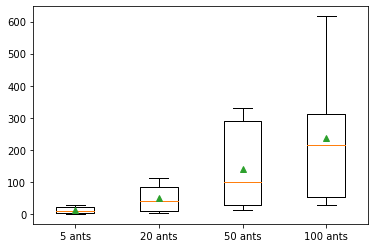

In [165]:
df_raw_data       =  pd.read_excel("Statistics/Stats.xlsx", sheet_name="raw_data_time")
plt.boxplot(df_raw_data, showmeans=True, whis=99)
plt.xticks([1,2,3,4], ['5 ants','20 ants','50 ants', '100 ants']) # x axis 

### - Linear regression

We do a linear regression to prove that there is indeed a relationship between time and the number of ants and iterations.

In [133]:
'''
We retrieve the data from the excel and we put them in an array
'''
column_iterations = ['50', '100', '250', '500', '750', '1000', '50', '100', '250', '500', '750', '1000', '50', '100', '250', '500', '750', '1000', '50', '100', '250', '500', '750', '1000']
column_ant        = ['5', '20', '50', '100']

row_50    =  [1.537703681, 5.668295622, 14.3081943, 28.14949439]
row_100   =  [3.003315997, 11.31219928, 28.18013237, 55.59757698]
row_250   =  [7.062337661, 29.24488859, 69.14218488, 145.6640782]
row_500   =  [14.37825725, 56.5766535, 134.8058088, 291.5259361]
row_750   =  [21.59912853, 85.26116035, 291.5259361, 311.5847677]
row_1000  =  [27.43953161, 111.298529, 317.2646895, 587.4532856]

data_ant  = [[5,   row_50[0]], [5,   row_100[0]], [5,   row_250[0]], [5,   row_500[0]], [5,   row_750[0]], [5,   row_1000[0]], 
             [20,  row_50[1]], [20,  row_100[1]], [20,  row_250[1]], [20,  row_500[1]], [20,  row_750[1]], [20,  row_1000[1]],
             [50,  row_50[2]], [50,  row_100[2]], [50,  row_250[2]], [50,  row_500[2]], [50,  row_750[2]], [50,  row_1000[2]],
             [100, row_50[3]], [100, row_100[3]], [100, row_250[3]], [100, row_500[3]], [100, row_750[3]], [100, row_1000[3]]]

#data_iter = ["50", row_50[0], "100", row_50[1], "250", row_50[2], "500", row_50[3], "750", row_50[0], 
#
#            "20", row_50[1], "20", row_100[1], "20", row_250[1], "20", row_500[1], "20", row_1000[1]
#           ]

#total_row = [row_50, row_100, row_250, row_500]

df_ant       = pd.DataFrame(data_ant, columns=['n_ant', 'time'], index=column_iterations)

#df_iteration = pd.DataFrame(test,     columns=['n_iter', 'time'], index=column_ant)

print(df_ant)

      n_ant        time
50        5    1.537704
100       5    3.003316
250       5    7.062338
500       5   14.378257
750       5   21.599129
1000      5   27.439532
50       20    5.668296
100      20   11.312199
250      20   29.244889
500      20   56.576653
750      20   85.261160
1000     20  111.298529
50       50   14.308194
100      50   28.180132
250      50   69.142185
500      50  134.805809
750      50  291.525936
1000     50  317.264689
50      100   28.149494
100     100   55.597577
250     100  145.664078
500     100  291.525936
750     100  311.584768
1000    100  587.453286


[6.32396062]
[[2.37886574]]
Variance score: 0.3616090941773725
-------------------------


        Actual   Predicted
0     1.537704   18.218289
1     3.003316   18.218289
2     7.062338   18.218289
3    14.378257   18.218289
4    21.599129   18.218289
5    27.439532   18.218289
6     5.668296   53.901275
7    11.312199   53.901275
8    29.244889   53.901275
9    56.576653   53.901275
10   85.261160   53.901275
11  111.298529   53.901275
12   14.308194  125.267248
13   28.180132  125.267248
14   69.142185  125.267248
15  134.805809  125.267248
16  291.525936  125.267248
17  317.264689  125.267248
18   28.149494  244.210535
19   55.597577  244.210535
20  145.664078  244.210535
21  291.525936  244.210535
22  311.584768  244.210535
23  587.453286  244.210535


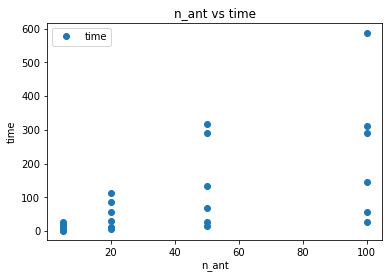

In [130]:
'''
We perform linear regression
'''

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

X = df_ant['n_ant'].values.reshape(-1,1)
Y = df_ant['time'].values.reshape(-1,1)

regressor = LinearRegression()  
regressor.fit(X, Y) #training the algorithm

#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(regressor.score(X, Y)))
print("-------------------------\n\n")

#Y_pred = regressor.predict(X_test)
Y_pred = regressor.predict(X)

df_time_2 = pd.DataFrame({'Actual': Y.flatten(), 'Predicted': Y_pred.flatten()})
print(df_time_2)

df_ant.plot(x='n_ant', y='time', style='o')  
plt.title('n_ant vs time')  
plt.xlabel('n_ant')  
plt.ylabel('time')  
plt.show()

We display the difference between the prediction and the current one

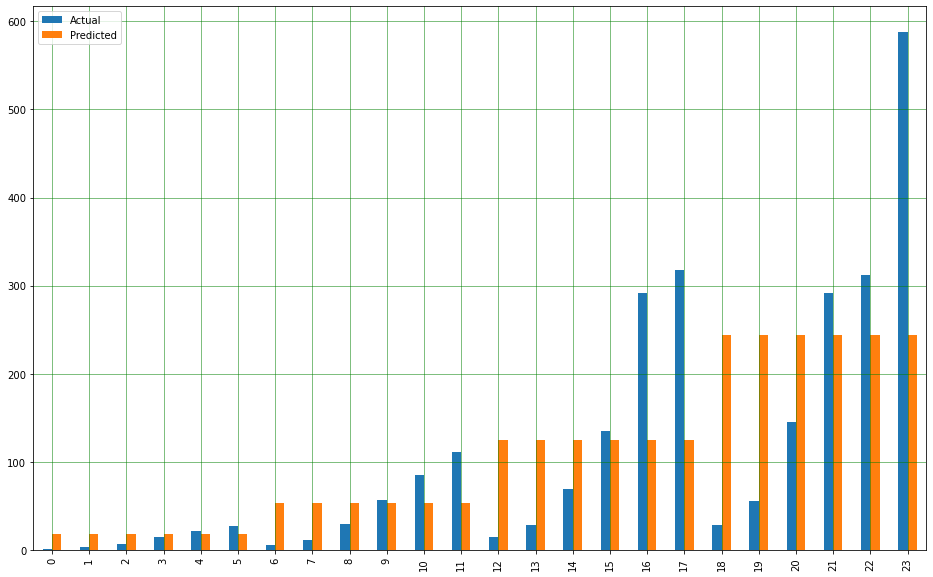

In [131]:
df8 = df_time_2.head(25)
df8.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

And we end up plotting the linear regression line

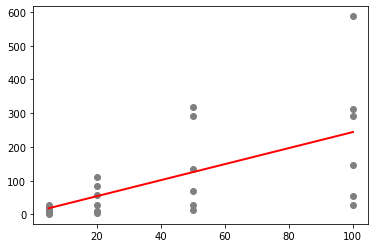

In [132]:
plt.scatter(X, Y,  color='gray')
plt.plot(X, Y_pred, color='red', linewidth=2)
plt.show()

So, even with little data we can easily see that there is a correlation between the execution time and the number of ants and iterations

# CONCLUSION

# Possible improvement

- Display the order of passage of the cities on the map<br>
<br>
- Optimize the algorithm<br>
<br>
- Have a better distribution of trucks (the VRP) and not just take out a truck according to storage.
<br>
-Do more testing and analysis on the algorithm